<a href="https://colab.research.google.com/github/Gregtom3/vossen_ecal_ai/blob/main/notebooks/nb02_shapeId.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial Overview

In this notebook, we use object condensation as a tool to identify shapes in an image.

## Imports

In [ ]:
# Import source code from the GitHub to generate images
!wget https://raw.githubusercontent.com/Gregtom3/vossen_ecal_ai/main/src/shape_gen.py
from shape_gen import generate_dataset

# Import source code from the GitHub for the object condensation loss function
!wget https://raw.githubusercontent.com/Gregtom3/vossen_ecal_ai/main/src/nb02_loss_functions.py
from nb02_loss_functions import CustomLoss, AttractiveLossMetric, RepulsiveLossMetric, CowardLossMetric, NoiseLossMetric

--2025-03-10 20:31:37--  https://raw.githubusercontent.com/Gregtom3/vossen_ecal_ai/main/src/shape_gen.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4600 (4.5K) [text/plain]
Saving to: ‘shape_gen.py.2’

shape_gen.py.2      100%[===================>]   4.49K  --.-KB/s    in 0s      

2025-03-10 20:31:37 (48.7 MB/s) - ‘shape_gen.py.2’ saved [4600/4600]

--2025-03-10 20:31:37--  https://raw.githubusercontent.com/Gregtom3/vossen_ecal_ai/main/src/nb02_loss_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7219 (7.0K) [te

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from copy import deepcopy
import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display,  clear_output

## Data Generation

Below we provide some of the parameters for creating an array of images. By default, we produce 1,000 images in a 32-by-32 grid containing $5-8$ shapes. A few other parameters like `same_color`, `same_shape` and `shape_overlap_max` can be tweaked.

In [ ]:
num_images           = 1000
image_width          = 32
image_height         = image_width
min_shapes           = 5
max_shapes           = 8
shape_size_range     = (5,12)

dataset = generate_dataset(num_images=num_images,
                           image_size=(image_width,image_height),
                           min_shapes=min_shapes,
                           max_shapes=max_shapes,
                           shape_size_range=shape_size_range,
                           same_color=False, # True
                           same_shape=None, # ['circle','triangle','square']
                           shape_overlap_max=0.5)
print(dataset.shape)

# --> 0,1,2 = RGB
# --> 3 = x
# --> 4 = y
# --> 5 = unique_shape_id (background == 0)
# --> 6 = shape type
#     --> 0 = noise/empty
#     --> 1 = circle
#     --> 2 = square
#     --> 3 = triangle

(1000, 32, 32, 7)


From `dataset.shape`, we see we are dealing with a tensor of dimension [1000,32,32,7]. As indicated by the comment, the first 3 features for each pixel are its RGB. Then, the (x,y) of the pixel is stored as the 4th and 5th feature. **The most crucial feature** to understand is the 6th, the "unique_shape_id".

Consider the first image, first shape. All pixels that correspond to that shape will have a `unique_shape_id` of 1. Then, for the second generated shape, they will have a `unique_shape_id` of 2, and so on. An important distinction is that no two shapes, even across different "events" will have the same `unique_shape_id`. All background pixels have a `unique_shape_id` of 0.

Lastly, the final feature indicates what type of shape the pixel belongs to.


Lets plot some sample event.



In [ ]:
def plot_toy(dataset, evtnum, PLOT_TYPE):
    # Check inputs
    assert PLOT_TYPE in ['RGB', 'X', 'Y', 'uid', 'type'], "PLOT_TYPE must be one of ['RGB', 'X', 'Y', 'uid', 'type']"
    assert evtnum < len(dataset), "evtnum must be less than the number of events in the dataset"

    # Copy and process the event data
    data_reshape = deepcopy(dataset[evtnum].numpy())
    if PLOT_TYPE == 'RGB':
        image_data = data_reshape[:, :, 0:3]
    elif PLOT_TYPE == 'X':
        image_data = data_reshape[:, :, 3]
    elif PLOT_TYPE == 'Y':
        image_data = data_reshape[:, :, 4]
    elif PLOT_TYPE == 'uid':
        image_data = data_reshape[:, :, 5]
    elif PLOT_TYPE == 'type':
        image_data = data_reshape[:, :, 6]

    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    im = ax.imshow(image_data)  # Capture the image object
    # Add a colorbar if the plot type is not RGB
    if PLOT_TYPE != 'RGB':
        fig.colorbar(im, ax=ax)
    # Set the title based on the widget inputs
    ax.set_title(f'Event: {evtnum} | Plot Type: {PLOT_TYPE}')
    plt.tight_layout()
    plt.show()

# Update function for the widget
def update_plot(event_num, plot_type):
    plot_toy(dataset, event_num, plot_type)

# Create the interactive widgets
event_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(dataset)-1,
    step=1,
    description='Event Number:'
)
plot_type_dropdown = widgets.Dropdown(
    options=['RGB', 'X', 'Y', 'uid', 'type'],
    value='RGB',
    description='Plot Type:'
)

# Link the widgets to the update function
interactive_plot = interactive(update_plot, event_num=event_slider, plot_type=plot_type_dropdown)
display(interactive_plot)

interactive(children=(IntSlider(value=0, description='Event Number:', max=999), Dropdown(description='Plot Typ…

Now that we are more familiar with our data, lets talk about what we will be doing. Our goal is to explore how object condensation can be used to perform clustering of these shapes. Using our own eyes, we can quite easily pick out how many shapes are in a given picture, AND what pixels belong to which shapes, simply by using the RGB. In fact, I suppose you could develop a really simple solution to the problem by sorting by unique RGB, but you may run into issues if you were to set `same_color=True` in the data generation stage.

Lets walk towards the problem slowly. First, lets train a neural network to perform some simpler tasks.


# Task A: Coverage

One simple task we can aim to solve with AI is as follows:

**Given**: A tensor of shape [32,32,3]

**Predict**: The percentage of occupied space in the image.

The reason why our tensor is now of shape [32,32,3] is that we only want our model to use the RGB of the pixels. We could also see what happens if we provide our model with [32,32,5] where we include the `x,y` features, but I will leave that up to you to experiment with. The key is not to provide the model with any identifying information, since that would be considered "true" info.

The architecture we will build for this is a simple Convolutional Neural Network (CNN). The network will actually be fed an input with dimensions `(B,32,32,3)` where `B` is the batch size. If you are unfamiliar with CNNs, they form the backbone of both early and modern computer vision architectures. I would encourage you to read more about them here https://www.geeksforgeeks.org/introduction-convolution-neural-network/. You should be able to answer for yourself *what is receptive field?*, *what does changing the kernel size do?* and *why do we do max pooling?*

First, lets get the `X` and `y` for the model. An important detail is that we set the background pixels to have an RGB of 0. The model will have a much more difficult time training if the background pixels have such a large signal value since "white" is (1,1,1). The only consequence of this is cosmetic. Now background pixels are **black**.

X.shape (1000, 32, 32, 3)
y.shape (1000,)


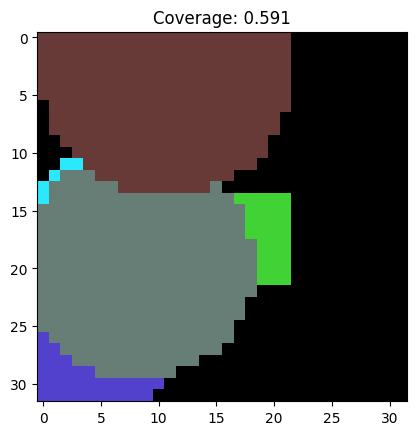

In [ ]:
# Slice out the RGB columns
X = np.array(dataset[...,:3])

# Set white pixels to black
X[dataset[...,5]==0] = 0

# Get the coverage
y = np.sum(dataset[...,5]!=0, axis=(1,2))/X.shape[1]**2

# Print
print("X.shape", X.shape)
print("y.shape", y.shape)

# Plot a random event with its coverage
evtnum = np.random.randint(0, len(X))
plt.imshow(X[evtnum])
plt.title(f'Coverage: {y[evtnum]:.3f}')
plt.show()

## Building a CNN

Next we will construct a CNN using Tensorflow.

The network combines convolutional layers with 3x3 kernels, 2x2 max pooling, and dropout. The model finishes with two dense layers, one with 128 nodes, and the final with 1.

A sigmoid activation function is chosen on the final node to make sure the output is between 0 and 1.

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

class TaskA_CNN(tf.keras.Model):
    def __init__(self):
        super(TaskA_CNN, self).__init__()
        # Convolutional and pooling layers with dropout
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop1 = tf.keras.layers.Dropout(0.1)

        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop2 = tf.keras.layers.Dropout(0.1)

        # Flatten and dense layers
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.drop3 = tf.keras.layers.Dropout(0.1)

        # Output layer with sigmoid
        # !!! This is done so the output is always between 0 and 1 !!!
        self.out = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, x, training=False):
        x = self.conv1(x) # output [B, W, H, 32]
        x = self.pool1(x) # output [B, W/2, H/2, 32]
        x = self.drop1(x, training=training)
        x = self.conv2(x) # output [B, W/2, H/2, 64]
        x = self.pool2(x) # output [B, W/4, H/4, 64]
        x = self.drop2(x, training=training)
        x = self.flatten(x) # output [B, W/4 * H/4 * 64]
        x = self.dense1(x)  # output [B, 128]
        x = self.drop3(x, training=training)
        return self.out(x) # output [B,1]

# Instantiate and build the model
model = TaskA_CNN()

## Training

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mean squared error loss, adam optimizer
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Perform fit (save `history`)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)

# Make predictions using the trained model
y_pred = model.predict(X)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0014 - mae: 0.0302 - val_loss: 0.0016 - val_mae: 0.0325
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0012 - mae: 0.0274 - val_loss: 0.0026 - val_mae: 0.0422
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0012 - mae: 0.0272 - val_loss: 0.0014 - val_mae: 0.0303
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 8.5171e-04 - mae: 0.0231 - val_loss: 0.0014 - val_mae: 0.0311
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 7.6033e-04 - mae: 0.0219 - val_loss: 0.0015 - val_mae: 0.0310
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 8.0290e-04 - mae: 0.0227 - val_loss: 0.0016 - val_mae: 0.0319
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 7.4333e-04 - mae: 0.0219 - val_loss: 0.0020 - val_mae: 0.0360
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 7.8701e-04 - mae: 0.0224 - val_loss: 0.0013 - val_mae: 0.0290
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 46m

## Evaluating

Here we show the loss as a function of training epoch.

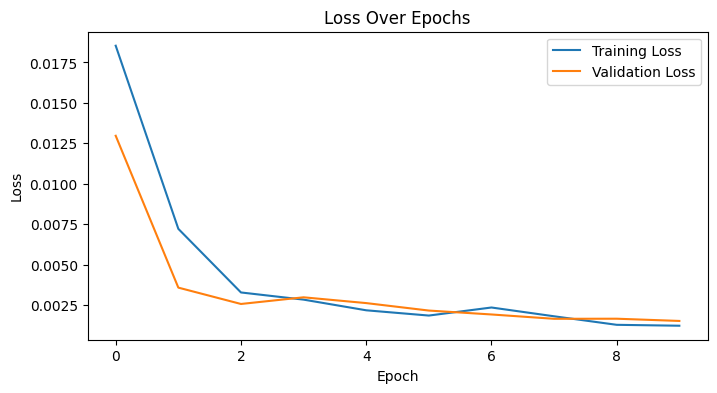

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In the plots below, we pick a random event and compare the image's actual coverage with the CNN prediction. We see fairly good agreement, which could be improved further with a larger training set, a deep model, and more epochs.

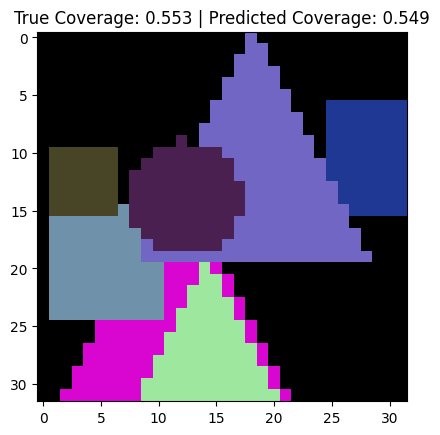

In [ ]:
# Select a random event
evtnum = np.random.randint(0, len(X))

# Plot the image
plt.imshow(X[evtnum])
plt.title(f'True Coverage: {y[evtnum]:.3f} | Predicted Coverage: {y_pred[evtnum][0]:.3f}')
plt.show()

Lastly, we can generate a heat map of the *true* vs *predicted* coverage across all events.

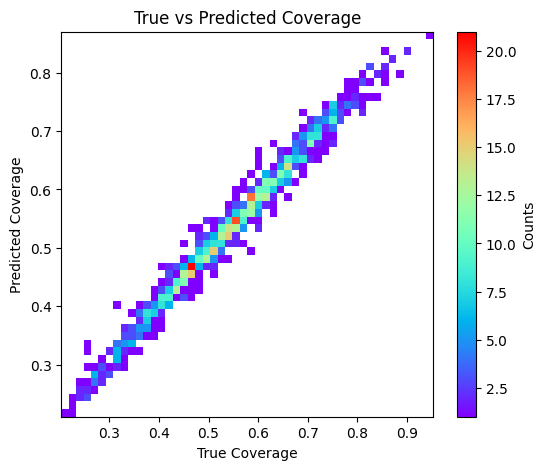

In [ ]:
# Create a 2D histogram
plt.figure(figsize=(6, 5))
plt.hist2d(np.array(y_true).flatten(), np.array(y_pred).flatten(), bins=50, cmap="rainbow",cmin=1)

# Add colorbar
plt.colorbar(label="Counts")

# Labels and title
plt.xlabel("True Coverage")
plt.ylabel("Predicted Coverage")
plt.title("True vs Predicted Coverage")

# Set background to white
plt.gca().set_facecolor("white")

# Show plot
plt.show()

If this is your first time seeing a CNN in action, perhaps you feel a bit unimpressed. *Shouldn't this have been more challenging?* We practically wrote 15 lines of code defining a model, a couple lines loading in some data, and a line to fit the data. *Where is the time sink?*

As you will eventually learn yourself, *building* and *fitting* the model are the easy parts. Preparing the data, now that is the hard part. Also, knowing what model to use, or being able to have the contextual knowledge to know why your model isn't working, why it isn't learning what you want it to - **that** takes a lot of time.


# Task B: Square hunting

Another simple task we can aim to solve with AI is as follows:

**Given**: A tensor of shape [32,32,3]

**Predict**: Does the image contain a square (0 or 1)?

This is a *classification* task, which implies we will need some sort of [LogLoss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html). However, the model infrastructure generally can remain the same. We still want, after all, the output of the CNN to be between 0 and 1.

For this, we will be making a new dataset with two shapes per image to make the odds of not having a square larger.



## New dataset

In [ ]:
new_dataset = generate_dataset(num_images=num_images,
                              image_size=(image_width,image_height),
                              min_shapes=2,
                              max_shapes=2,
                              shape_size_range=shape_size_range,
                              same_color=False, # True
                              same_shape=None, # ['circle','triangle','square']
                              shape_overlap_max=0.5)

X.shape (1000, 32, 32, 3)
y.shape (1000,)


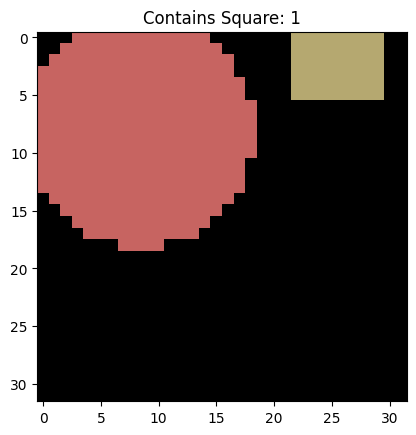

In [ ]:
X = np.array(new_dataset[...,:3])
X[new_dataset[...,5]==0] = 0
y = np.any(new_dataset[...,6]==3, axis=(1,2)).astype(int)

# Print
print("X.shape", X.shape)
print("y.shape", y.shape)

# Plot a random event with whether or not it contains a square
evtnum = np.random.randint(0, len(X))
plt.imshow(X[evtnum])
plt.title(f'Contains Square: {y[evtnum]}')
plt.show()

## Building a CNN

In [ ]:
class TaskB_CNN(tf.keras.Model):
    def __init__(self):
        super(TaskB_CNN, self).__init__()
        # Convolutional and pooling layers with dropout
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop1 = tf.keras.layers.Dropout(0.1)

        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop2 = tf.keras.layers.Dropout(0.1)

        # Flatten and dense layers
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.drop3 = tf.keras.layers.Dropout(0.1)

        # Output layer with sigmoid
        # !!! This is done so the output is always between 0 and 1 !!!
        self.out = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, x, training=False):
        x = self.conv1(x) # output [B, W, H, 32]
        x = self.pool1(x) # output [B, W/2, H/2, 32]
        x = self.drop1(x, training=training)
        x = self.conv2(x) # output [B, W/2, H/2, 64]
        x = self.pool2(x) # output [B, W/4, H/4, 64]
        x = self.drop2(x, training=training)
        x = self.flatten(x) # output [B, W/4 * H/4 * 64]
        x = self.dense1(x)  # output [B, 128]
        x = self.drop3(x, training=training)
        return self.out(x) # output [B,1]

# Instantiate and build the model
model = TaskB_CNN()

## Training

Here we are using a different `loss` function, the `binary_crossentropy`. This is used when we are dealing with a single-class classification problem where the true value is either 0 (no) or 1 (yes).

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Binary cross entropy, adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Perform fit (save `history`)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=32
)

# Make predictions using the trained model
y_pred = model.predict(X)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.5806 - loss: 0.6890 - val_accuracy: 0.5900 - val_loss: 0.6617
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6340 - loss: 0.6227 - val_accuracy: 0.6850 - val_loss: 0.5988
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6789 - loss: 0.5657 - val_accuracy: 0.7600 - val_loss: 0.5073
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.7492 - loss: 0.4916 - val_accuracy: 0.7600 - val_loss: 0.4740
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7895 - loss: 0.4405 - val_accuracy: 0.7550 - val_loss: 0.4643
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8645 - loss: 0.3275 - val_accuracy: 0.8450 - val_loss: 0.3536
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8985 - loss: 0.2681 - val_accuracy: 0.8500 - val_loss: 0.3847
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9222 - loss: 0.2246 - val_accuracy: 0.8350 - v

## Evaluating

Loss function

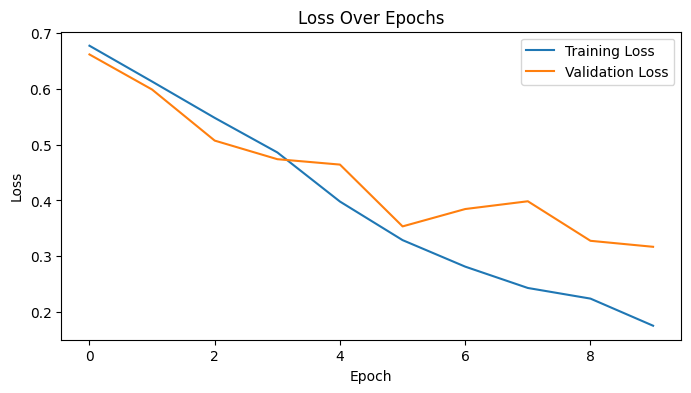

In [ ]:
# Plot the loss function of train and test vs. epoch
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plotting the model output into a single histogram. As you can see, a majority of the events where a square is in the image have a very large model output, near 1. The fact that these two classes are well separated in the model output space demonstrates that the model has a strong discriminating power.

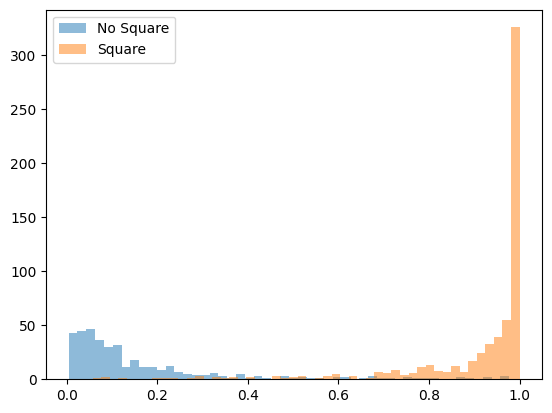

In [ ]:
# Plot model output into a histogram
plt.hist(y_pred[y==0], bins=50, alpha=0.5, label='No Square')
plt.hist(y_pred[y==1], bins=50, alpha=0.5, label='Square')
plt.legend()
plt.show()

Plot the ROC curve. The ROC curve indicates how well a classifier performs at different threshold values. Depending on the threshold (minimum classifier output) chosen, the precision, accuracy, etc. of the model can change. As a basic example of this, consider the output `y=f(x)` of the classifier `f`. If we apply a cut of `y>0`, we effectively have perfect recall. However, the accuracy and precision will be poor.

More information about ROC curves can be found here https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc. The AUC or "Area Under Curve" is an important metric for determining the discriminating power of the model. An AUC above 0.9 indicates a strong model.

Text(0, 0.5, 'True Positive Rate')

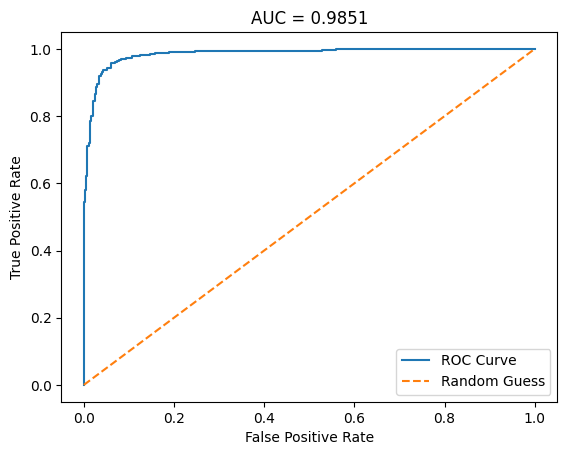

In [ ]:
# Plot the ROC curve and calculate the AUC
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC Curve')

plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.title(f'AUC = {roc_auc:.4f}')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Plotting a random event and comparing the model predictions.

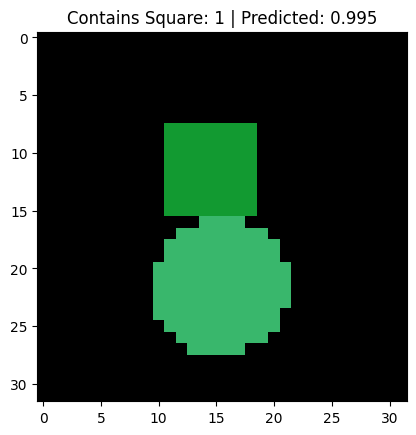

In [ ]:
# Plot a random event and show if the model predicts a square
evtnum = np.random.randint(0, len(X))
plt.imshow(X[evtnum])
plt.title(f'Contains Square: {y[evtnum]} | Predicted: {y_pred[evtnum][0]:.3f}')
plt.show()

Lastly, **and what I feel is always best to check**, is what events have *the largest loss*. Understanding why an event's loss is large is critical for understanding how to improve your model, or to recognize why it might fail.

Based on these plots, it is not immediately clear to me why the model feels so strongly that there is a square. It might be worth noting that for these cases, the shapes fall partly outside the grid.

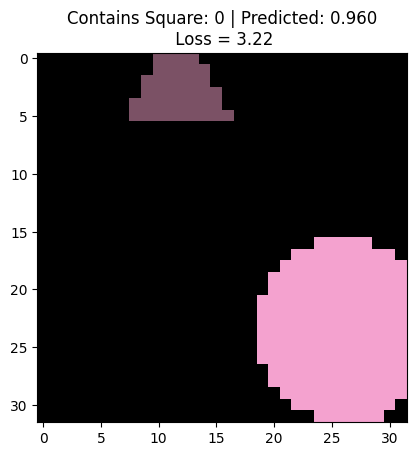

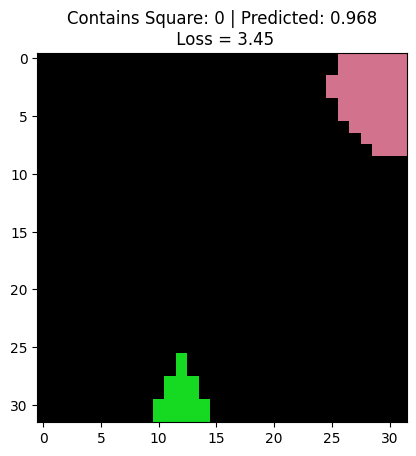

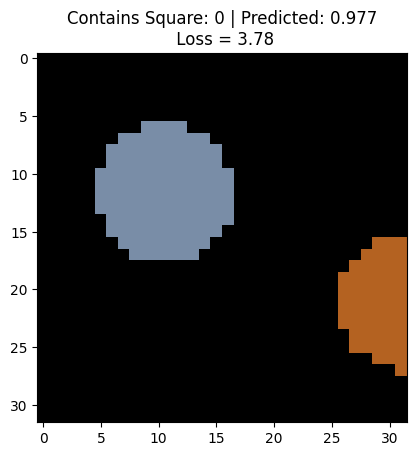

In [ ]:
# Plot the 3 events whose loss is the largest
loss = tf.keras.losses.BinaryCrossentropy()
losses = [loss(y[i:i+1],y_pred[i:i+1]) for i in range(len(y))]
for evtnum in np.argsort(losses)[-3:]:
    plt.imshow(X[evtnum])
    plt.title(f'Contains Square: {y[evtnum]} | Predicted: {y_pred[evtnum][0]:.3f}\n Loss = {losses[evtnum]:.2f}')
    plt.show()

# Task C: Object Condensation

At this stage, it is time to approach the clustering problem head on. The problem statement is as follows:

**Given**: An input image of size [32,32,3].

**Predict**: Which pixels belong to the same shape.

As you might be able to tell, this is a drastically different expectation than tasks A and B. For starters, those two tasks only asked for a single output per image. That meant that the final node of our network could be of size 1, without issue. However, now we are essentially demanding one prediction for each of the pixels. That is quite challenging for our simple CNN to wrap its mind around.

Another challenge is scope. Imagine a training sample with a maximum of 8 shapes per image. Even if our model could perfectly fit the training set, we must have a method we are confident in to solve cases with more than 8 shapes. We do not want it to fail the moment we ask it to find potentially 9 or more clusters.

The solution to the problem lies in the definition of the loss function. The loss function in Task A was mean-squared error (common in regression tasks) and the loss function in Task B was binary cross entropy (common in classification tasks). To solve the clustering problem, this paper https://arxiv.org/abs/2002.03605 developed a new loss function that a neural network may want to minimize - the object condensation loss

## What is the Object Condensation Loss Function(s)?

The object condensation loss is calculated from the output of some neural network. In object condensation, each pixel (whether it is background or not) *learns* a confidence/brightness value $\beta$ (between 0 and 1) and a location in a latent space. This latent space, for our case, has dimension 2.

The main idea is that all pixels belonging to the same object are mapped to the same point in this latent space. These pixels are huddled together in the latent space. Pixels belongning to different objects are encouraged to spread apart from one another. This way, a perfectly trained model that minimizes the object condensation loss produces a latent space that is inherently pre-clustered.

Let us see this in action. In the widget below, we simply generate a square (left), and then map each pixel of that square to a point in the latent space (right).

### Object Condensation Schematic 1

Button(description='1) Make square', layout=Layout(width='200px'), style=ButtonStyle())

Button(description='2) Map to latent space', layout=Layout(width='200px'), style=ButtonStyle())

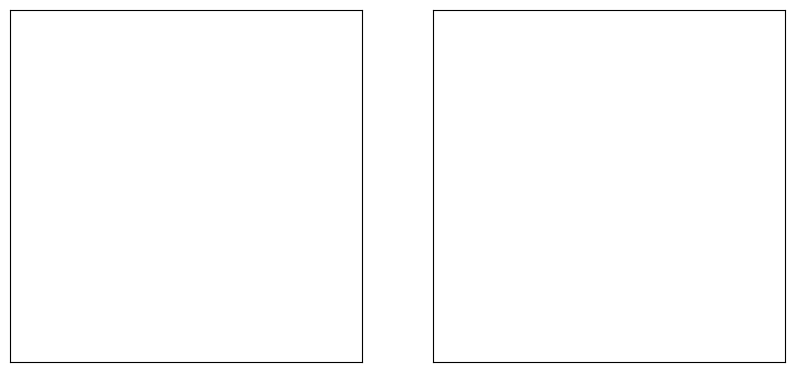

In [ ]:
# Global flags and storage for square and dot positions
left_drawn = False
right_drawn = False
red_square_coords = None
red_dots_coords = None  # will store a tuple (x_array, y_array) for red dots

def update_plot():
    clear_output(wait=True)
    # Create a new figure with two subplots
    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(10, 5))

    # Create a white 64x64 RGB image for both subplots
    white_img = np.ones((64, 64, 3))

    # Set each axes background to white
    ax_left.set_facecolor('white')
    ax_right.set_facecolor('white')

    # Display the white image with an extent to set the axes limits from 0 to 64
    ax_left.imshow(white_img, extent=[0, 64, 0, 64])
    ax_right.imshow(white_img, extent=[0, 64, 0, 64])

    # Remove axis ticks for a cleaner look
    for ax in (ax_left, ax_right):
        ax.set_xticks([])
        ax.set_yticks([])

    # Draw the red square in the left subplot if triggered
    if left_drawn and red_square_coords is not None:
        x, y = red_square_coords
        square_left = patches.Rectangle((x, y), 10, 10, edgecolor='red', facecolor='red', lw=2)
        ax_left.add_patch(square_left)

    # Draw 100 red dots in the right subplot if triggered
    if right_drawn and red_dots_coords is not None:
        x_vals, y_vals = red_dots_coords
        ax_right.scatter(x_vals, y_vals, color='red', s=20)  # s sets the marker size

    # Re-display the buttons (they get cleared with clear_output)
    display(button_left, button_right)

    # Finally, show the updated figure
    plt.show()

def on_button1_clicked(b):
    global left_drawn, red_square_coords, right_drawn, red_dots_coords
    left_drawn = True
    # When a new red square is created, clear any existing scatter data.
    right_drawn = False
    red_dots_coords = None
    # Generate new random coordinates for the red square ensuring it fits within 64x64.
    red_square_coords = (np.random.randint(0, 64 - 10), np.random.randint(0, 64 - 10))
    update_plot()

def on_button2_clicked(b):
    global right_drawn, red_dots_coords
    # Scatter only if there is an active red square.
    if not left_drawn or red_square_coords is None:
        return
    right_drawn = True
    # Generate 100 random (x, y) positions for red dots within the 64x64 area.
    x_vals = np.random.uniform(0, 64, 100)
    y_vals = np.random.uniform(0, 64, 100)
    red_dots_coords = (x_vals, y_vals)
    update_plot()

# Create the buttons
button_left = widgets.Button(description="1) Make square",layout=widgets.Layout(width='200px'))
button_right = widgets.Button(description="2) Map to latent space",layout=widgets.Layout(width='200px'))

# Link the buttons to their corresponding functions
button_left.on_click(on_button1_clicked)
button_right.on_click(on_button2_clicked)

# Display the initial plot and buttons
update_plot()

When clicking "Map to latent space", we see that the points just randomly fill the 2-d latent space. Remember, each of those red dots is supposed to represent a pixel on the left plot. What we want is for the red dots on the right to merge together. *Object condensation defines an 'attractive loss' term that rewards the model for mapping points belonging to the same object to the same location in the latent space*.

### Object Condensation Schematic 2

How does it do this? First, lets revisit the $\beta$ term. This term, called the confidence value, determines (in an abstract sense) how likely this particular pixel **represents** the object. Lets let $\beta$ be associated with "brightness" or in this case "opacity" of the right plot. There is a loss term in object condensation that *rewards the model for having one bright $\beta$ per object*. This term, called the **coward loss** , is minimized (technically) if all pixels have a $\beta=1$. However, due to how $\beta$ is folded into other terms in the loss function, its actually advantageous for the model to learn only 1 bright $\beta$. Lets see that in action.


Button(description='1) Make square', layout=Layout(width='200px'), style=ButtonStyle())

Button(description='2) Map to latent space', layout=Layout(width='200px'), style=ButtonStyle())

Button(description='3) Minimize coward loss', layout=Layout(width='200px'), style=ButtonStyle())

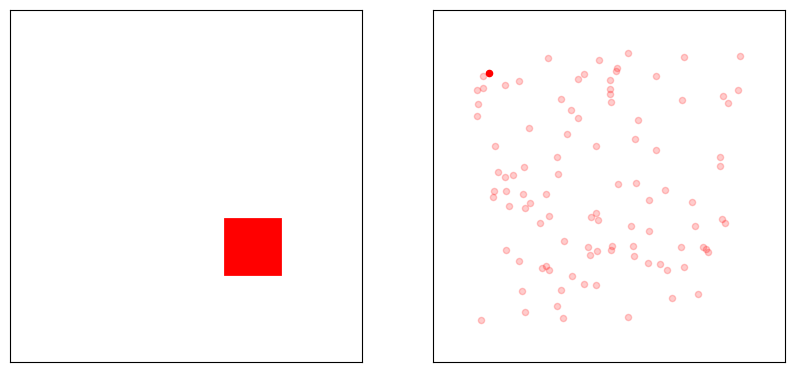

In [ ]:
# Global flags and storage for square and dot positions
left_drawn = False
right_drawn = False
red_square_coords = None
red_dots_coords = None  # will store a tuple (x_array, y_array) for red dots
minimize_loss_called = False  # flag to indicate the third button was pressed

def update_plot():
    clear_output(wait=True)
    # Create a new figure with two subplots
    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(10, 5))

    # Create a white 64x64 RGB image for both subplots
    white_img = np.ones((64, 64, 3))

    # Set each axes background to white
    ax_left.set_facecolor('white')
    ax_right.set_facecolor('white')

    # Display the white image with an extent to set the axes limits from 0 to 64
    ax_left.imshow(white_img, extent=[0, 64, 0, 64])
    ax_right.imshow(white_img, extent=[-10, 74, -10, 74])

    # Remove axis ticks for a cleaner look
    for ax in (ax_left, ax_right):
        ax.set_xticks([])
        ax.set_yticks([])

    # Draw the red square in the left subplot if triggered
    if left_drawn and red_square_coords is not None:
        x, y = red_square_coords
        square_left = patches.Rectangle((x, y), 10, 10, edgecolor='red', facecolor='red', lw=2)
        ax_left.add_patch(square_left)

    # Draw red dots in the right subplot if triggered
    if right_drawn and red_dots_coords is not None:
        x_vals, y_vals = red_dots_coords
        if minimize_loss_called:
            # Redraw with new alpha: first point alpha=1, others alpha=0.2
            ax_right.scatter(x_vals[0:1], y_vals[0:1], color='red', s=20, alpha=1)
            ax_right.scatter(x_vals[1:], y_vals[1:], color='red', s=20, alpha=0.2)
        else:
            ax_right.scatter(x_vals, y_vals, color='red', s=20)

    # Re-display the buttons (they get cleared with clear_output)
    display(button_left, button_right, button_three)

    # Finally, show the updated figure
    plt.show()

def on_button1_clicked(b):
    global left_drawn, red_square_coords, right_drawn, red_dots_coords, minimize_loss_called
    left_drawn = True
    # When a new red square is created, clear any existing scatter data and reset the minimize flag.
    right_drawn = False
    red_dots_coords = None
    minimize_loss_called = False
    # Generate new random coordinates for the red square ensuring it fits within 64x64.
    red_square_coords = (np.random.randint(0, 64 - 10), np.random.randint(0, 64 - 10))
    update_plot()

def on_button2_clicked(b):
    global right_drawn, red_dots_coords, minimize_loss_called
    # Scatter only if there is an active red square.
    if not left_drawn or red_square_coords is None:
        return
    right_drawn = True
    # Reset minimize flag if scatter is re-called.
    minimize_loss_called = False
    # Generate 100 random (x, y) positions for red dots within the 64x64 area.
    x_vals = np.random.uniform(0, 64, 100)
    y_vals = np.random.uniform(0, 64, 100)
    red_dots_coords = (x_vals, y_vals)
    update_plot()

def on_button3_clicked(b):
    global minimize_loss_called
    # "Minimize coward loss": only works if scatter data exists.
    if not right_drawn or red_dots_coords is None:
        return
    minimize_loss_called = True
    update_plot()

# Create the buttons
button_left = widgets.Button(description="1) Make square",layout=widgets.Layout(width='200px'))
button_right = widgets.Button(description="2) Map to latent space",layout=widgets.Layout(width='200px'))
button_three = widgets.Button(description="3) Minimize coward loss",layout=widgets.Layout(width='200px'))

# Link the buttons to their corresponding functions
button_left.on_click(on_button1_clicked)
button_right.on_click(on_button2_clicked)
button_three.on_click(on_button3_clicked)

# Display the initial plot and buttons
update_plot()


### Object Condensation Schematic 3

Now we are ready to understand how object condensation encourages clustering. For each object, the **attractive loss** is calculated by summing the distance between the *condensation point* (in our case the point with the highest $\beta$) and the remaining points. It is thus minimized as the points are drawn towards one another. The reason why points gravitate towards one condensation point rather than each other is due to computational overhead.

Next, play with the widget below by making a red square, mapping to the latent space, highlighting the brightest $\beta$, and then clicking the 4th button. With each press of the fourth button, we imagine the object condensation loss, when calculated, gets lower and lower

Button(description='1) Make square', layout=Layout(width='200px'), style=ButtonStyle())

Button(description='2) Map to latent space', layout=Layout(width='200px'), style=ButtonStyle())

Button(description='3) Minimize coward loss', layout=Layout(width='200px'), style=ButtonStyle())

Button(description='4) Minimize attractive loss', layout=Layout(width='200px'), style=ButtonStyle())

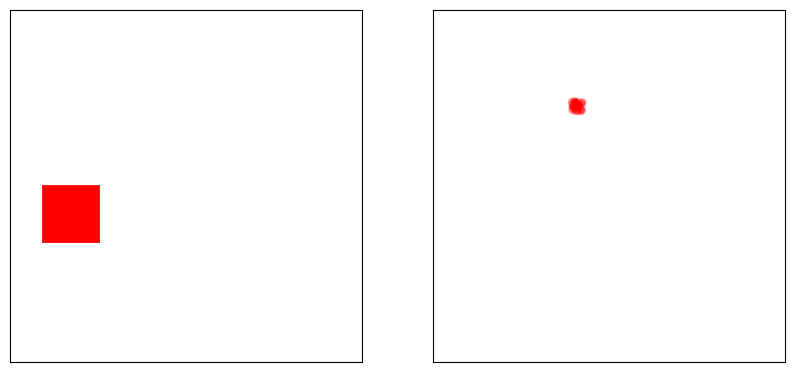

In [ ]:
# Global flags and storage for square and dot positions
left_drawn = False
right_drawn = False
red_square_coords = None
red_dots_coords = None  # will store a tuple (x_array, y_array) for red dots
minimize_loss_called = False  # flag to indicate the third button was pressed

def update_plot():
    clear_output(wait=True)
    # Create a new figure with two subplots
    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(10, 5))

    # Create a white 64x64 RGB image for both subplots
    white_img = np.ones((64, 64, 3))

    # Set each axes background to white
    ax_left.set_facecolor('white')
    ax_right.set_facecolor('white')

    # Display the white image with an extent to set the axes limits
    ax_left.imshow(white_img, extent=[0, 64, 0, 64])
    ax_right.imshow(white_img, extent=[-10, 74, -10, 74])

    # Remove axis ticks for a cleaner look
    for ax in (ax_left, ax_right):
        ax.set_xticks([])
        ax.set_yticks([])

    # Draw the red square in the left subplot if triggered
    if left_drawn and red_square_coords is not None:
        x, y = red_square_coords
        square_left = patches.Rectangle((x, y), 10, 10, edgecolor='red', facecolor='red', lw=2)
        ax_left.add_patch(square_left)

    # Draw red dots in the right subplot if triggered
    if right_drawn and red_dots_coords is not None:
        x_vals, y_vals = red_dots_coords
        if minimize_loss_called:
            # First dot (bright red) at full opacity; others at alpha 0.1.
            ax_right.scatter(x_vals[0:1], y_vals[0:1], color='red', s=20, alpha=1)
            ax_right.scatter(x_vals[1:], y_vals[1:], color='red', s=20, alpha=0.1)
        else:
            ax_right.scatter(x_vals, y_vals, color='red', s=20)

    # Re-display the buttons (they get cleared with clear_output)
    display(button_left, button_right, button_three, button_four)

    # Finally, show the updated figure
    plt.show()

def on_button1_clicked(b):
    global left_drawn, red_square_coords, right_drawn, red_dots_coords, minimize_loss_called
    left_drawn = True
    # When a new red square is created, clear any existing scatter data and reset the minimize flag.
    right_drawn = False
    red_dots_coords = None
    minimize_loss_called = False
    # Generate new random coordinates for the red square ensuring it fits within 64x64.
    red_square_coords = (np.random.randint(0, 64 - 10), np.random.randint(0, 64 - 10))
    update_plot()

def on_button2_clicked(b):
    global right_drawn, red_dots_coords, minimize_loss_called
    # Scatter only if there is an active red square.
    if not left_drawn or red_square_coords is None:
        return
    right_drawn = True
    # Reset minimize flag if scatter is re-called.
    minimize_loss_called = False
    # Generate 100 random (x, y) positions for red dots within the 64x64 area.
    x_vals = np.random.uniform(0, 64, 100)
    y_vals = np.random.uniform(0, 64, 100)
    red_dots_coords = (x_vals, y_vals)
    update_plot()

def on_button3_clicked(b):
    global minimize_loss_called
    # "Minimize coward loss": only works if scatter data exists.
    if not right_drawn or red_dots_coords is None:
        return
    minimize_loss_called = True
    update_plot()

def on_button4_clicked(b):
    global red_dots_coords
    # "Minimize attractive loss": move all red dots 25% closer to the bright red dot.
    # Only works if scatter data exists.
    if not right_drawn or red_dots_coords is None:
        return
    x_vals, y_vals = red_dots_coords
    # Use the bright red dot (first dot) as the anchor.
    bright_x, bright_y = x_vals[0], y_vals[0]
    # Move all dots 25% closer to the bright dot:
    new_x_vals = bright_x + 0.75 * (x_vals - bright_x)
    new_y_vals = bright_y + 0.75 * (y_vals - bright_y)
    red_dots_coords = (new_x_vals, new_y_vals)
    update_plot()

# Create the buttons with a wider layout.
button_left = widgets.Button(description="1) Make square", layout=widgets.Layout(width='200px'))
button_right = widgets.Button(description="2) Map to latent space", layout=widgets.Layout(width='200px'))
button_three = widgets.Button(description="3) Minimize coward loss", layout=widgets.Layout(width='200px'))
button_four = widgets.Button(description="4) Minimize attractive loss", layout=widgets.Layout(width='200px'))

# Link the buttons to their corresponding functions
button_left.on_click(on_button1_clicked)
button_right.on_click(on_button2_clicked)
button_three.on_click(on_button3_clicked)
button_four.on_click(on_button4_clicked)

# Display the initial plot and buttons
update_plot()

### Object Condensation Schematic 4

Now, we will explore what happens when we have multiple objects. We generate both a red and blue square in the next widget.

We want the model to identify one condensation point for each object, which is why *Minimize coward loss* will create only one bright red and one bright blue point.

We also want the attractive loss for each object to be separately minimized. We want the red dots to collect near their red condensation point, and the blue dots to collect near their blue condensation point.

We also want to encourage an additional behavior - repulsion. We do not want the red points to be anywhere near the blue condensation point, and vice versa. To encourage this, a **repulsive** loss term is defined by object condensation.

In the following widget, we see this in action. You can press buttons 1,2,3 as before, and then flip between pressing buttons 4 and 5 to see the impact of attraction and repulsion separately in the latent space. You can even set `COLORS` to a much longer array of colors to see more action!

Button(description='1) Make squares', layout=Layout(width='200px'), style=ButtonStyle())

Button(description='2) Map to latent space', layout=Layout(width='200px'), style=ButtonStyle())

Button(description='3) Minimize coward loss', layout=Layout(width='200px'), style=ButtonStyle())

Button(description='4) Minimize attractive loss', layout=Layout(width='200px'), style=ButtonStyle())

Button(description='5) Minimize repulsive loss', layout=Layout(width='200px'), style=ButtonStyle())

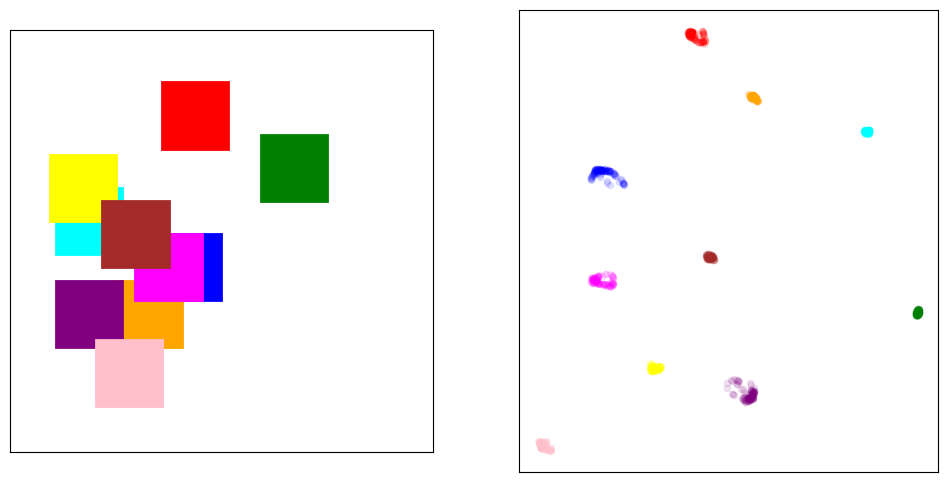

In [ ]:
# List of colors for flexibility – add as many colors as needed.
# COLORS = ['red', 'blue']  # For example, change to ['red', 'blue', 'green', 'orange'] for 4 squares
COLORS = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'brown', 'pink']
# Global flags and data structures
left_drawn = False   # Indicates that squares have been created
right_drawn = False  # Indicates that latent scatter has been mapped
minimize_loss_called = False  # Flag for bright spot effect ("Minimize coward loss")

# Dictionaries to hold square coordinates and scatter points for each color.
squares = {}        # Format: { color: (x, y) }
scatter_points = {} # Format: { color: (x_array, y_array) }

def update_plot():
    clear_output(wait=True)
    # Create figure with two subplots: left for squares, right for latent space scatter.
    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 6))

    # Left subplot: 64x64 white background.
    white_img = np.ones((64, 64, 3))
    ax_left.set_facecolor('white')
    ax_left.imshow(white_img, extent=[0, 64, 0, 64])
    ax_left.set_xticks([])
    ax_left.set_yticks([])

    # Draw each square.
    for color in COLORS:
        if color in squares and squares[color] is not None:
            x, y = squares[color]
            rect = patches.Rectangle((x, y), 10, 10, edgecolor=color, facecolor=color, lw=2)
            ax_left.add_patch(rect)

    # Right subplot: white background with extended extents.
    ax_right.set_facecolor('white')
    ax_right.imshow(white_img, extent=[-10, 74, -10, 74])
    ax_right.set_xticks([])
    ax_right.set_yticks([])

    # Draw scatter points if latent mapping exists.
    if right_drawn and all(color in scatter_points and scatter_points[color] is not None for color in COLORS):
        for color in COLORS:
            x_vals, y_vals = scatter_points[color]
            if minimize_loss_called:
                # First (bright) point full opacity; others lower.
                ax_right.scatter(x_vals[0:1], y_vals[0:1], color=color, s=20, alpha=1)
                ax_right.scatter(x_vals[1:], y_vals[1:], color=color, s=20, alpha=0.1)
            else:
                ax_right.scatter(x_vals, y_vals, color=color, s=20)

    # Display buttons.
    display(button1, button2, button3, button4, button5)
    plt.show()

def on_button1_clicked(b):
    global left_drawn, right_drawn, minimize_loss_called, squares, scatter_points
    left_drawn = True
    right_drawn = False
    minimize_loss_called = False
    # Clear any existing scatter data.
    scatter_points = {color: None for color in COLORS}
    # Generate new random positions for each square (ensuring a 10x10 square fits in 64x64).
    squares = {color: (np.random.randint(0, 64-10), np.random.randint(0, 64-10)) for color in COLORS}
    update_plot()

def on_button2_clicked(b):
    global right_drawn, scatter_points, minimize_loss_called
    if not left_drawn or any(squares.get(color) is None for color in COLORS):
        return
    right_drawn = True
    minimize_loss_called = False
    # Generate 100 random scatter points for each color within the 64x64 region.
    scatter_points = {color: (np.random.uniform(0, 64, 100), np.random.uniform(0, 64, 100))
                      for color in COLORS}
    update_plot()

def on_button3_clicked(b):
    global minimize_loss_called
    # "Minimize coward loss": brighten each set's first point.
    if not right_drawn or any(scatter_points.get(color) is None for color in COLORS):
        return
    minimize_loss_called = True
    update_plot()

def on_button4_clicked(b):
    global scatter_points
    # "Minimize attractive loss": move each color's scatter points 25% closer to its own bright point.
    if not right_drawn or any(scatter_points.get(color) is None for color in COLORS):
        return
    for color in COLORS:
        x_arr, y_arr = scatter_points[color]
        bright_x, bright_y = x_arr[0], y_arr[0]
        new_x_arr = bright_x + 0.75 * (x_arr - bright_x)
        new_y_arr = bright_y + 0.75 * (y_arr - bright_y)
        scatter_points[color] = (new_x_arr, new_y_arr)
    update_plot()

def on_button5_clicked(b):
    global scatter_points
    # "Minimize repulsive loss": for each color's scatter points, move them 5 units away from the bright spots of every other color.
    if not right_drawn or any(scatter_points.get(color) is None for color in COLORS):
        return
    for color in COLORS:
        x_arr, y_arr = scatter_points[color]
        total_disp_x = np.zeros_like(x_arr)
        total_disp_y = np.zeros_like(y_arr)
        for other in COLORS:
            if other == color:
                continue
            other_x_arr, other_y_arr = scatter_points[other]
            # Use the bright spot (first point) of the other color as anchor.
            bright_x = other_x_arr[0]
            bright_y = other_y_arr[0]
            vec_x = x_arr - bright_x
            vec_y = y_arr - bright_y
            norms = np.sqrt(vec_x**2 + vec_y**2)
            # Avoid division by zero.
            disp_x = np.where(norms == 0, 0, 5 * vec_x / norms)
            disp_y = np.where(norms == 0, 0, 5 * vec_y / norms)
            total_disp_x += disp_x
            total_disp_y += disp_y
        new_x_arr = x_arr + total_disp_x
        new_y_arr = y_arr + total_disp_y
        scatter_points[color] = (new_x_arr, new_y_arr)
    update_plot()

# Create buttons with wider layouts.
button1 = widgets.Button(description="1) Make squares", layout=widgets.Layout(width='200px'))
button2 = widgets.Button(description="2) Map to latent space", layout=widgets.Layout(width='200px'))
button3 = widgets.Button(description="3) Minimize coward loss", layout=widgets.Layout(width='200px'))
button4 = widgets.Button(description="4) Minimize attractive loss", layout=widgets.Layout(width='200px'))
button5 = widgets.Button(description="5) Minimize repulsive loss", layout=widgets.Layout(width='200px'))

# Link buttons to their functions.
button1.on_click(on_button1_clicked)
button2.on_click(on_button2_clicked)
button3.on_click(on_button3_clicked)
button4.on_click(on_button4_clicked)
button5.on_click(on_button5_clicked)

update_plot()
